<a href="https://colab.research.google.com/github/dongzooo/Quant-with-py/blob/main/%EC%BA%94%EB%93%A4%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%B6%84%EC%84%9D/%EC%A2%85%EB%AA%A9%EB%B3%84_%EC%88%98%EC%9D%B5%EC%8B%A4%ED%98%84_%EC%A7%84%EC%9E%85%EC%9E%90%EB%A6%AC_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import pandas as pd
import datetime
from google.colab import files

import seaborn as sns
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import Logit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Colab 의 한글 폰트 설정
# plt.rc('font', family='NanumBarunGothic')

# 유니코드에서  음수 부호설정
matplotlib.rc('axes', unicode_minus=False)

In [ ]:
files.upload()

In [30]:
#수익 목록 업로드
profitRecord = pd.read_csv(f"/content/gainsTransactions.csv")
profitRecord = profitRecord.drop(profitRecord.columns[0], axis=1)
profitRecord.columns = ['Timestamp', 'Order', 'Code', 'Name', 'price']
profitRecord['Timestamp'] = pd.to_datetime(profitRecord['Timestamp'], format="%y-%m-%d %H:%M:%S")
profitRecord = profitRecord.drop_duplicates().sort_values('Timestamp').reset_index(drop=True)

In [31]:
#종목별로 파일을 불러 알고리즘을 돌리기위해 종목명만 담은 알고리즘을 생성했다.
tempProfitRecord = profitRecord
stocks = tempProfitRecord["Name"].tolist()

In [ ]:
#기존 분봉데이터와 진입시점 비교하기 위해 초데이터 0으로 초기화
profitRecord["Timestamp"] = profitRecord["Timestamp"].dt.floor("Min")
profitRecord

In [33]:
# 변곡발생만 검색
def findInflection(n, df, col_name):
    turning_points = []
    start_num = n + 1
    for i in range(start_num, len(df)):
      # 변곡 발생
      if (df[col_name].iloc[i] > df[col_name].iloc[i - 1] <= df[col_name].iloc[i - 2]):
              turning_points.append(i)
    return turning_points

In [34]:
df1Min = pd.DataFrame()
df3Min = pd.DataFrame()
df5Min = pd.DataFrame()
df10Min = pd.DataFrame()

In [54]:
def getProfitPoint(i):
  df1Min = pd.read_csv(f"/content/ytd1MinData{stocks[i]}.csv")
  df1Min = df1Min.drop(df1Min.columns[0], axis=1)
  df1Min.columns = ['Timestamp', 'Open', 'High', 'Low', 'Close','Volume']
  df1Min['Timestamp'] = pd.to_datetime(df1Min['Timestamp'], format="%y-%m-%d %H:%M:%S")
  df1Min = df1Min.drop_duplicates().sort_values('Timestamp').reset_index(drop=True)
  df1Min["Name"] = profitRecord.loc[i]["Name"]

  df3Min = pd.read_csv(f"/content/ytd3MinData{stocks[i]}.csv")
  df3Min = df3Min.drop(df3Min.columns[0], axis=1)
  df3Min.columns = ['Timestamp', 'Open', 'High', 'Low', 'Close','Volume']
  df3Min['Timestamp'] = pd.to_datetime(df3Min['Timestamp'], format="%y-%m-%d %H:%M:%S")
  df3Min = df3Min.drop_duplicates().sort_values('Timestamp').reset_index(drop=True)

  df10Min = pd.read_csv(f"/content/ytd10MinData{stocks[i]}.csv")
  df10Min = df10Min.drop(df10Min.columns[0], axis=1)
  df10Min.columns = ['Timestamp', 'Open', 'High', 'Low', 'Close','Volume']
  df10Min['Timestamp'] = pd.to_datetime(df10Min['Timestamp'], format="%y-%m-%d %H:%M:%S")
  df10Min = df10Min.drop_duplicates().sort_values('Timestamp').reset_index(drop=True)

  df30Min = pd.read_csv(f"/content/ytd30MinData{stocks[i]}.csv")
  df30Min = df30Min.drop(df30Min.columns[0], axis=1)
  df30Min.columns = ['Timestamp', 'Open', 'High', 'Low', 'Close','Volume']
  df30Min['Timestamp'] = pd.to_datetime(df30Min['Timestamp'], format="%y-%m-%d %H:%M:%S")
  df30Min = df30Min.drop_duplicates().sort_values('Timestamp').reset_index(drop=True)

  '''1분봉 '''
  #거래 이평선
  df1Min['2VMA'] = df1Min['Volume'].rolling(window=2).mean()
  df1Min['5VMA'] = df1Min['Volume'].rolling(window=5).mean()
  df1Min['10VMA'] = df1Min['Volume'].rolling(window=10).mean()
  df1Min['20VMA'] = df1Min['Volume'].rolling(window=20).mean()
  df1Min['1Min_5VMA우상향'] = df1Min['5VMA'].pct_change().apply(lambda x: 1 if x >= 0 else 0)
  df1Min['1Min_20VMA우상향'] = df1Min['20VMA'].pct_change().apply(lambda x: 1 if x >= 0 else 0)
    #df1Min 정배열
  df1Min['1Min5_20VMA정배열'] = df1Min.apply(lambda row: 1 if row['5VMA'] > row['20VMA'] else 0, axis=1)
  df1Min['1Min2_5_10_20VMA정배열'] = df1Min.apply(lambda row: 1 if row['2VMA'] > row['5VMA'] > row['10VMA'] > row['20VMA'] else 0, axis=1)

  '''3분봉'''
  #거래 이평선 생성
  df3Min['2VMA'] = df3Min['Volume'].rolling(window=2).mean()
  df3Min['5VMA'] = df3Min['Volume'].rolling(window=5).mean()
  df3Min['10VMA'] = df3Min['Volume'].rolling(window=10).mean()
  df3Min['20VMA'] = df3Min['Volume'].rolling(window=20).mean()
    #df3Min 정배열
  df3Min['3Min5_20VMA정배열'] = df3Min.apply(lambda row: 1 if row['5VMA'] > row['20VMA'] else 0, axis=1)
  df3Min['3Min2_5_10_20VMA정배열'] = df3Min.apply(lambda row: 1 if row['2VMA'] > row['5VMA'] > row['10VMA'] > row['20VMA'] else 0, axis=1)

  '''10분봉'''
  #거래 이평선 생성
  df10Min['2VMA'] = df10Min['Volume'].rolling(window=2).mean()
  df10Min['3VMA'] = df10Min['Volume'].rolling(window=3).mean()
  df10Min['10Min2_3VMA정배열'] = df10Min.apply(lambda row: 1 if row['2VMA'] > row['3VMA'] else 0, axis=1)
  df10Min['10Min_2VMA우상향'] = df10Min['2VMA'].pct_change().apply(lambda x: 1 if x >= 0 else 0)
  df10Min['10Min_3VMA우상향'] = df10Min['3VMA'].pct_change().apply(lambda x: 1 if x >= 0 else 0)

  #거래이평 변곡
  df10MinInf = pd.DataFrame(columns=df10Min.columns)
  turning_points = findInflection(2,df10Min,"2VMA")
  for i in turning_points:
    df10MinInf = df10MinInf._append(df10Min.iloc[i],ignore_index=True)

  df10Min['10M_2VMA변곡'] = 0
  df10Min.loc[df10Min['Timestamp'].isin(df10MinInf['Timestamp']), '10M_2VMA변곡'] = 1

  '''30분봉'''
  #거래 이평선 생성
  df30Min['2VMA'] = df30Min['Volume'].rolling(window=2).mean()
  df30Min['3VMA'] = df30Min['Volume'].rolling(window=3).mean()
  df30Min['30Min2_3VMA정배열'] = df30Min.apply(lambda row: 1 if row['2VMA'] > row['3VMA'] else 0, axis=1)
  df30Min['30Min_2VMA우상향'] = df30Min['2VMA'].pct_change().apply(lambda x: 1 if x > 0 else 0)

  #거래이평 변곡
  df30MinInf = pd.DataFrame(columns=df30Min.columns)
  turning_points = findInflection(2,df30Min,"2VMA")
  for i in turning_points:
    df30MinInf = df30MinInf._append(df30Min.iloc[i],ignore_index=True)

  df30Min['30M_2VMA변곡'] = 0
  df30Min.loc[df30Min['Timestamp'].isin(df30MinInf['Timestamp']), '30M_2VMA변곡'] = 1

  #3,10,30분봉과 1분봉 시계열 시작 맞추기 + 우상향생성
  df1Min['Timestamp'].iloc[0]
  df3Min = df3Min[df3Min['Timestamp'] >= df1Min['Timestamp'].iloc[0]]
  df3Min = df3Min.reset_index(drop=True)

  df10Min = df10Min[df10Min['Timestamp'] >= df1Min['Timestamp'].iloc[0]]
  df10Min['2VMA우상향'] = df10Min['2VMA'].pct_change().apply(lambda x: 1 if x >= 0 else 0)
  df10Min = df10Min.reset_index(drop=True)

  df30Min = df30Min[df30Min['Timestamp'] >= df1Min['Timestamp'].iloc[0]]
  df30Min['2VMA우상향'] = df30Min['2VMA'].pct_change().apply(lambda x: 1 if x > 0 else 0)
  df30Min = df30Min.reset_index(drop=True)


  #df1Min에 정배열 정의
  #df1Min에 3분봉 10분봉 30분봉 시간선 데이터 추가
  df1Min['3분단위'] = df1Min['Timestamp'].dt.floor('3min')
  df1Min['10분단위'] = df1Min['Timestamp'].dt.floor('10min')
  df1Min['30분단위'] = df1Min['Timestamp'].dt.floor('30min')

  #df1Min 에 넣을 데이터들
  df1Min["3Min5_20VMA정배열"] = 0
  df1Min['10M_2VMA우상향'] = 0
  df1Min['30M_2VMA우상향'] = 0
  df1Min['10Min2_3VMA정배열'] = 0
  df1Min['10Min_2VMA우상향'] = 0
  df1Min['10Min_3VMA우상향'] = 0
  df1Min['30Min2_3VMA정배열'] = 0
  df1Min['30Min_2VMA우상향'] = 0
  df1Min['3Min2_5_10_20VMA정배열'] = 0

  for i in range(len(df3Min)):
      timestamp = df3Min.loc[i, 'Timestamp']
      mask = df1Min['3분단위'] == timestamp
      df1Min.loc[mask, '3Min5_20VMA정배열'] = df3Min.loc[i, '3Min5_20VMA정배열']
      df1Min.loc[mask, '3Min2_5_10_20VMA정배열'] = df3Min.loc[i, '3Min2_5_10_20VMA정배열']


  for i in range(len(df10Min)):
      timestamp = df10Min.loc[i, 'Timestamp']
      mask = df1Min['10분단위'] == timestamp
      df1Min.loc[mask, '10M_2VMA우상향'] = df10Min.loc[i, '2VMA우상향']
      df1Min.loc[mask, '10Min2_3VMA정배열'] = df10Min.loc[i, '10Min2_3VMA정배열']
      df1Min.loc[mask, '10M_2VMA변곡'] = df10Min.loc[i, '10M_2VMA변곡']
      df1Min.loc[mask, '10Min_2VMA우상향'] = df10Min.loc[i, '10Min_2VMA우상향']
      df1Min.loc[mask, '10Min_3VMA우상향'] = df10Min.loc[i, '10Min_3VMA우상향']


  for i in range(len(df30Min)):
      timestamp = df30Min.loc[i, 'Timestamp']
      mask = df1Min['30분단위'] == timestamp
      df1Min.loc[mask, '30M_2VMA우상향'] = df30Min.loc[i, '2VMA우상향']
      df1Min.loc[mask, '30Min2_3VMA정배열'] = df30Min.loc[i, '30Min2_3VMA정배열']
      df1Min.loc[mask, '30M_2VMA변곡'] = df30Min.loc[i, '30M_2VMA변곡']
      df1Min.loc[mask, '30Min_2VMA우상향'] = df30Min.loc[i, '30Min_2VMA우상향']

  # filtered_df = df1Min[df1Min["Timestamp"] == profitRecord.iloc[i]["Timestamp"]]



  return df1Min , profitRecord


In [55]:
  #'10Min_2VMA우상향','10Min_3VMA우상향','30Min_2VMA우상향','1Min_5VMA우상향','1Min_20VMA우상향','1Min2_5_10_20VMA정배열','3Min2_5_10_20VMA정배열'

In [56]:
#14시50분 이후 데이터는 날리는 작업은 이평성 생성후 한다
target_time = pd.to_datetime("14:50:00", format="%H:%M:%S").strftime('%H:%M:%S')
result_df = pd.DataFrame()

In [57]:
for i in range(len(stocks)):
  df1Min , profitRecordf = getProfitPoint(i)
  df = df1Min[df1Min["Timestamp"] == profitRecordf.iloc[i]["Timestamp"]]

  result_df = pd.concat([result_df, df], axis=0)

In [58]:
result_df = result_df.reset_index(drop=True)
result_df

,Timestamp,Open,High,Low,Close,Volume,Name,2VMA,5VMA,10VMA,...,10M_2VMA우상향,30M_2VMA우상향,10Min2_3VMA정배열,10Min_2VMA우상향,10Min_3VMA우상향,30Min2_3VMA정배열,30Min_2VMA우상향,3Min2_5_10_20VMA정배열,10M_2VMA변곡,30M_2VMA변곡
0,2023-06-15 10:41:00,71000,74200,71000,73600,21921,샘표,11591.0,6419.8,4983.2,...,1,1,1,1,1,1,1,0,0.0,0.0
1,2023-06-15 13:20:00,2285,2380,2265,2375,936896,DB,513104.5,217183.0,137465.1,...,1,0,1,1,1,0,0,0,1.0,NaN
2,2023-06-15 14:07:00,2505,2565,2505,2565,573629,대한광통신,315410.5,156708.6,113635.3,...,0,0,0,0,0,0,0,0,0.0,0.0
3,2023-06-15 14:13:00,68800,69500,68600,69400,21924,기가비스,13711.5,7038.2,5007.2,...,0,1,0,0,0,1,1,0,0.0,0.0
4,2023-06-15 14:46:00,21750,22600,21750,22400,190227,보라티알,130197.0,55952.2,31422.0,...,1,1,1,1,1,1,1,1,1.0,1.0
5,2023-06-16 10:00:00,2525,2730,2525,2715,1646320,태성,830096.5,336818.6,176333.2,...,1,1,1,1,1,1,1,1,1.0,0.0
6,2023-06-16 10:02:00,20850,21150,20850,21050,342562,이수페타시스,263823.5,115121.2,76711.9,...,1,0,0,1,1,0,0,0,1.0,0.0
7,2023-06-16 10:50:00,10860,11120,10800,10870,217624,레이저쎌,153247.5,113454.6,60537.1,...,1,1,1,1,1,1,1,1,0.0,0.0
8,2023-06-16 11:01:00,10440,10700,10440,10680,149805,피코그램,75843.5,32015.6,17523.5,...,1,1,1,1,1,1,1,1,1.0,1.0
9,2023-06-16 11:51:00,11150,11470,11150,11470,205864,레이저쎌,104378.5,45855.6,29192.7,...,1,0,1,1,1,0,0,0,1.0,0.0


In [46]:
result_df.drop(labels=['Open','High','Low','Close',"20VMA","5VMA",'Volume','3분단위','10분단위','30분단위'],axis=1,inplace=True)

In [52]:
columns = ["0종목명/종목수","1Min5_20VMA정배열","3Min5_20VMA정배열",'10Min2_3VMA정배열',"10M_2VMA우상향",'10M_2VMA변곡',
           '30Min2_3VMA정배열',"30M_2VMA우상향",'30M_2VMA변곡','10Min_2VMA우상향','10Min_3VMA우상향','30Min_2VMA우상향','1Min_5VMA우상향','1Min_20VMA우상향','1Min2_5_10_20VMA정배열',
           '3Min2_5_10_20VMA정배열']

# 'Profitable'이 1인 경우의 데이터프레임 추출
# df_profitable_1 = df1MinData[df1MinData['Profitable'] == 1]
# df_profitable_1 = df_profitable_1.reset_index(drop=True)
# len(df_profitable_1)

# 컬럼별로 퍼센트 계산
percentages = []
count = []
result_df["0종목명/종목수"] = 1
for column in columns:
    count.append(result_df[column].sum())
    percentage = (result_df[column].sum() / result_df.shape[0]) * 100
    percentages.append(round(percentage,2))

# 결과를 데이터프레임으로 정리
quant_df = pd.DataFrame({'Column': columns, 'Percentage(%)': percentages, 'Count':count})
quant_df = quant_df.sort_values('Column').reset_index(drop=True)

# 결과 출력
quant_df.sort_values(by='Percentage(%)', ascending=False).reset_index(drop=True)

,Column,Percentage(%),Count
0,0종목명/종목수,100.00,14.0
1,1Min_5VMA우상향,100.00,14.0
2,1Min5_20VMA정배열,92.86,13.0
3,1Min_20VMA우상향,92.86,13.0
4,10M_2VMA우상향,85.71,12.0
5,10Min_2VMA우상향,85.71,12.0
6,10Min2_3VMA정배열,78.57,11.0
7,10Min_3VMA우상향,78.57,11.0
8,1Min2_5_10_20VMA정배열,71.43,10.0
9,30M_2VMA우상향,71.43,10.0


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44257 (\N{HANGUL SYLLABLE GOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50864 (\N{HANGUL SYLLABLE U}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54693 (\N{HANGUL SYLLABLE HYANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packag

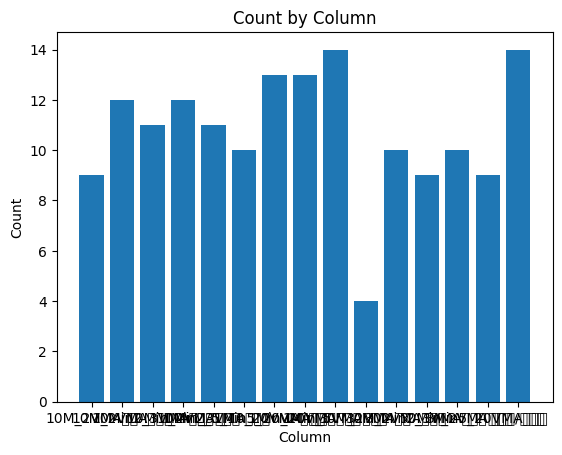

In [51]:
# 그래프 그리기
plt.bar(quant_df['Column'], quant_df['Count'])
plt.xlabel('Column')
plt.ylabel('Count')
plt.title('Count by Column')

# 그래프 출력
plt.show()

In [18]:
date = datetime.datetime.now().strftime("%Y%m%d")
today = datetime.date.today()
today

datetime.date(2023, 6, 20)

In [15]:
date = datetime.datetime.now().strftime("%Y%m%d")
today = datetime.date.today()
directory = f"./{today.strftime('%Y%m%d')}"
# os.makedirs(directory, exist_ok=True)

#결과 저장
quant_df.to_csv(f"{directory}_quant_df.csv", index=False)
result_df.to_csv(f"{directory}_result_df.csv", index=False)

In [ ]:
# quant_df = pd.read_csv("20230615_quant_df.csv")
# result_df = pd.read_csv("20230615_result_df.csv")
quant_df = pd.read_csv("20230616_quant_df.csv")
result_df = pd.read_csv("20230616_result_df.csv")

In [ ]:
result_df.iloc[8:10]

,Timestamp,Name,1Min5_20VMA정배열,3Min5_20VMA정배열,10M_2VMA우상향,30M_2VMA우상향,10Min2_3VMA정배열,30Min2_3VMA정배열,10M_2VMA변곡,30M_2VMA변곡
8,2023-06-15 10:47:00,태성,1,0,1,1,1,1,1.0,0.0
9,2023-06-15 11:05:00,한컴라이프케어,1,1,1,1,1,1,1.0,1.0


In [ ]:
quant_df

,Column,Percentage(%),Count
0,10M_2VMA우상향,100.00,12
1,1M_5&20VMA정배열,91.67,11
2,30M_2VMA우상향,100.00,12
3,3M_5&20VMA정배열,41.67,5
